In [13]:
import perceval as pcvl
import numpy as np
import sympy as sp

## Use the symbolic skin for display
from perceval.rendering.circuit import DisplayConfig, SymbSkin
from perceval.rendering.format import Format
DisplayConfig.select_skin(SymbSkin)

from lo_reservoir import PhotonicReservoirSimulator

### Circuit functions - old

In [135]:
def U_ij_t(i : int , j : int, t : int = 0):
    """Returns the unitary acting on mode i and j."""
    return (pcvl.Circuit(2, name=f"U_{i}{j}_t{t}")
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
            .add(0, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
            .add(0, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
            .add(1, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}"))))

U_12 = U_ij_t(1, 2)
pcvl.pdisplay(U_12)

[Parameter(name='phi_tl_12_t0', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi_bl_12_t0', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='theta_12_t0', value=None, min_v=0.0, max_v=12.566370614359172), Parameter(name='phi_tr_12_t0', value=None, min_v=0.0, max_v=6.283185307179586), Parameter(name='phi_br_12_t0', value=None, min_v=0.0, max_v=6.283185307179586)]


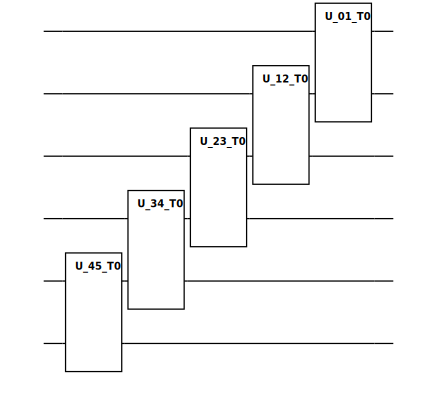

In [89]:
def full_layer(n : int, t : int = 0, ancilla : int = 0, _overlapping : bool = False):
    layer = pcvl.Processor(n + ancilla)
    if _overlapping:
        for i in range(n-2, -1, -1):
            layer = layer.add(i, U_ij_t(i, (i+1), t))
    else:
        if n % 2 != 0:
            print("WARNING: The number is not even and _overlapping is False => the last mode will be ignored.")
        for i in range((n)//2):
            layer = layer.add(2*i, U_ij_t(i, i+1, t))
    return layer

n = 6
t = 0
layer = full_layer(n, t, 2, True)
pcvl.pdisplay(layer)

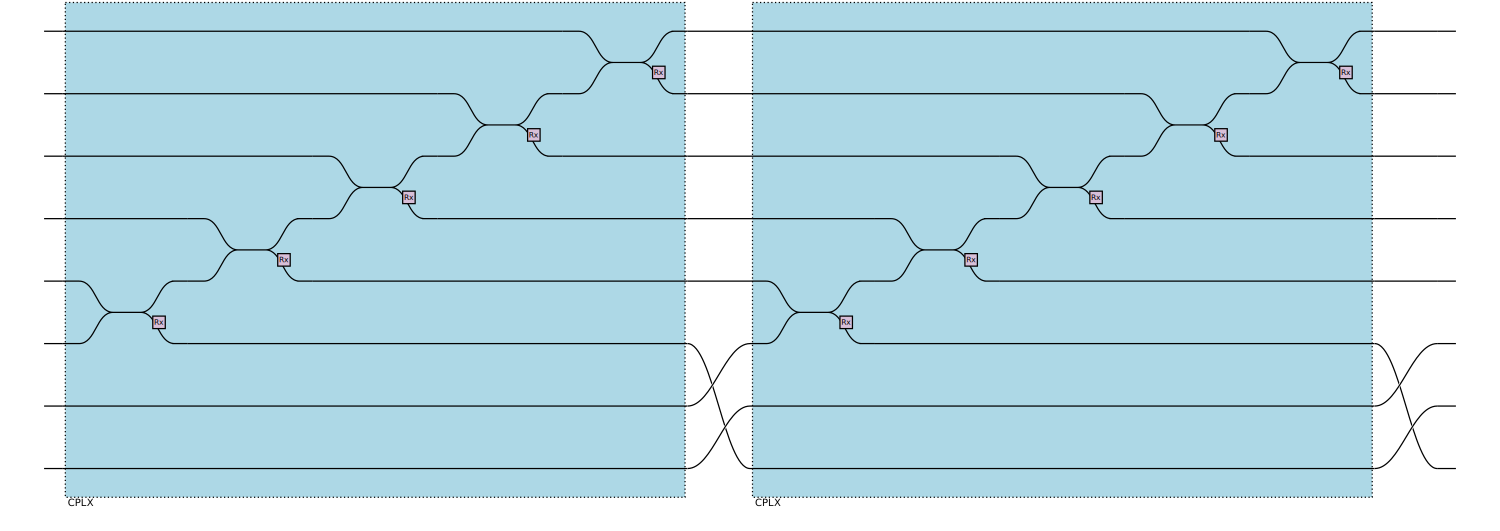

In [191]:
n = 6
t = 0
layer = pcvl.Circuit(8)
for i in range(n-2, -1, -1):
    if i == n-2:
        layer = layer.add(i, pcvl.BS())
    else:
        layer = layer.add(i, pcvl.BS())
process = pcvl.Processor("SLOS", layer)
process.add(5, pcvl.PERM([2,0,1]))
process.add(0, layer)
process.add(5, pcvl.PERM([2,0,1]))
pcvl.pdisplay(process, recursive=True)



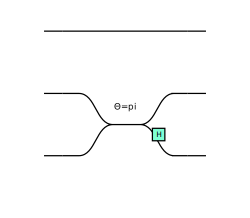

In [188]:
def initialize_processor(old_result=None, new_data_normalized=None, num_ancillas=1, N=None):
    assert 0 <= new_data_normalized <= 1 
    if new_data_normalized is None:
        new_data_normalized = 0.5
    if old_result is None:
        assert N is not None
        old_result = [1 for _ in range(N)]
    
    processor = pcvl.Processor("SLOS", len(old_result) + 2*num_ancillas)
    processor.with_input(pcvl.BasicState(old_result + num_ancillas*[1, 0]))
    processor.add(len(old_result), pcvl.BS.H(theta=np.pi*new_data_normalized))
    return processor

p = initialize_processor([2], 1, 1)
pcvl.pdisplay(p)

In [254]:
# init circuit
n = 5
ancilla = 1
layer = pcvl.Circuit(n + 2 * ancilla)
for i in range(n-1, -1, -1):
        layer = layer.add(i, pcvl.BS())
# init process with initial state |1,1,1,1,1,0,0> and data 0.431234
init_state = pcvl.BasicState([1,1,1,1,1])
data_0 = 0.4125235634
process = pcvl.Processor("SLOS", layer)
process = initialize_processor(list(init_state), data_0, 1)
process.add(0, layer)
pcvl.pdisplay(process, recursive=True)
# sample after first circuit layer
sampler = pcvl.algorithm.Sampler(process)
samples = sampler.samples(10000)
sample_count = sampler.sample_count(10000) 

output_state=max(sample_count['results'], key=sample_count['results'].get)
print(list(output_state))
# expectation = [0.0 for _ in range(n)]
# for state, prob in sampler.probs()['results']:
#     for mode in range(n):
#         expectation[mode] += state[mode] * prob

[2, 0, 0, 1, 1, 2, 0]


In [253]:
# print(sampler.probs()['results'])
process.set_postselection(pcvl.PostSelect("[1] == 1"))

[1]==1

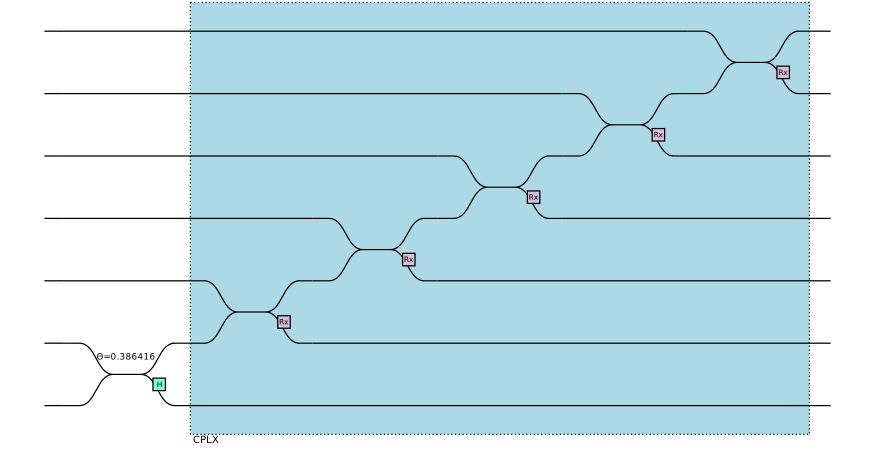

In [229]:
# 2nd iteration with data_1 = 0.123
data_1 = 0.123
p = initialize_processor(list(output_state[:5]), data_1, 1)
p.add(0, layer)
pcvl.pdisplay(p, recursive=True)

In [156]:
process.with_input(pcvl.BasicState(output_state))
sampler = pcvl.algorithm.Sampler(process)
samples = sampler.samples(10000)  # Sampler exposes 'samples' primitive returning a list of ordered samples

sample_count = sampler.sample_count(10000)  # Sampler exposes 'sample_count' returning a dictionary {state: count}

# print(sample_count['results'])
# prob_dist = sampler.probs() 
# print(prob_dist)
print(max(sample_count['results'], key=sample_count['results'].get))

|0,1,0,1,3,0,0,0>


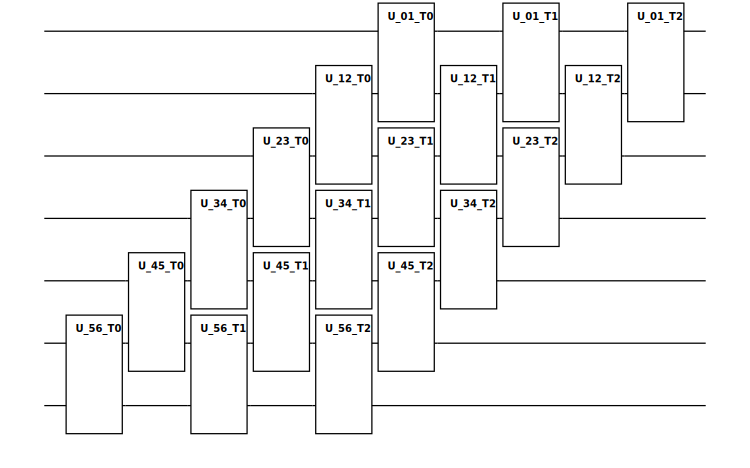

In [114]:
def create_circuit(n, depth, _overlapping=False):
    main_circuit = pcvl.Processor(n+depth)
    for t in range(depth):
        main_circuit = main_circuit.add(0, full_layer(n+1, t, depth-1, _overlapping))
    return main_circuit

# Example usage:
n = 6  # Number of modes
t = 3  # Number of times to repeat the layers
circuit = create_circuit(n, t, _overlapping=True)
pcvl.pdisplay(circuit)

### Imperfect Case - constant loss for each channel

Implemented the circuit with lossy channels, reused some code

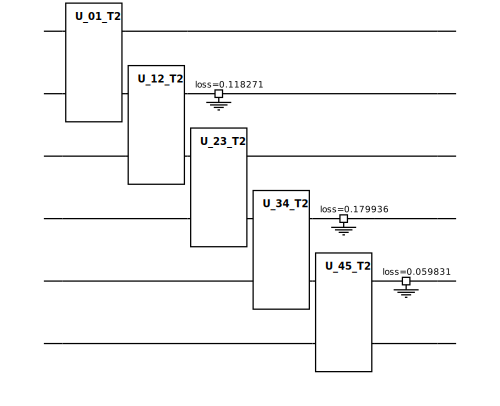

In [16]:
def generate_gaussian_0_1(mean, std_dev, num_samples):
    """
    Generate Gaussian samples on the interval [0,1].

    :param mean: The mean of the Gaussian distribution.
    :param std_dev: The standard deviation of the Gaussian distribution.
    :param num_samples: The number of samples to generate.
    """
    samples = []
    while len(samples) < num_samples:
        sample = np.random.normal(mean, std_dev)
        if sample >= 0 and sample <= 1:
            samples.append(sample)
    return np.array(samples)

def full_layer_loss(m : int, t : int = 0, _overlapping : bool = False, noise_mean : float = 0.1, noise_std : float = 0.2, noise_modes=[]):
    """
    Generates a full layer with loss.
    """
    layer = pcvl.Processor("SLOS", m, source=pcvl.Source(emission_probability=.6, multiphoton_component=.01))
    if _overlapping:
        for i in range(m-1):
            layer = layer.add(i, U_ij_t(i, (i+1), t))
    else:
        if m % 2 != 0:
            print("WARNING: The number is not even and _overlapping is False => the last mode will be ignored.")
        for i in range((m)//2):
            layer = layer.add(2*i, U_ij_t(i, i+1, t))
    if len(noise_modes) != 0:
        random_noise = generate_gaussian_0_1(noise_mean, noise_std, len(noise_modes))
        for i in range(len(noise_modes)):
            layer.add(int(noise_modes[i]), pcvl.LC(random_noise[i]), keep_port=True)
    return layer

layer_noisy = full_layer_loss(6, 2, True, noise_mean=0.1, noise_std=0.1, noise_modes=[1,3,4])
pcvl.pdisplay(layer_noisy)

[1, 3, 4]


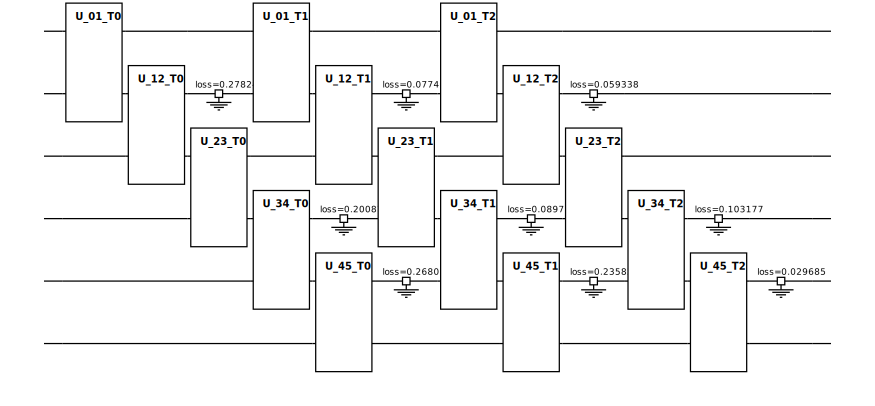

In [17]:
def create_circuit_loss(m, t, _overlapping=False, noise_mean=0.1, noise_std=0.1, noise_modes=[]):
    main_circuit = pcvl.Processor(m, source=pcvl.Source(emission_probability=.6, multiphoton_component=.01))
    print(noise_modes)
    for t in range(t):
        main_circuit = main_circuit.add(0, full_layer_loss(m, t, _overlapping, noise_mean, noise_std, noise_modes))
    return main_circuit

# Example usage:
n = 6  # Number of modes
t = 3  # Number of times to repeat the layers
circuit = create_circuit_loss(n, t, _overlapping=True, noise_mean=0.1, noise_std=0.1, noise_modes=[1,3,4])
pcvl.pdisplay(circuit)

In [10]:
# TODO: add photon after each layer, adjust with decay rate
# TODO: add dropout after last layer according to photon number at last layer

In [18]:
def calculate_mode_expectations(self, input_state : pcvl.BasicState = None):

        if input_state is None:
            print("WARNING: No input state provided. Using the vacuum state.")
            input_state = pcvl.BasicState([0] * self.m)

        backend = pcvl.BackendFactory.get_backend("SLOS")
        backend.set_circuit(self.circuit)
        backend.set_input_state(input_state)
        prob_distribution = backend.prob_distribution()

        expectations = [0.0 for _ in range(self.m)]
        for state, probability in prob_distribution.items():
            for mode in range(self.m):
                expectations[mode] += state[mode] * probability
        return expectations

In [22]:
circuit = create_circuit_loss(n, t, _overlapping=True, noise_mean=0.1, noise_std=0.1, noise_modes=[1,3,4])
init_state = pcvl.BasicState([1] * n)
pcvl.pdisplay(init_state)

[1, 3, 4]


RuntimeError: pdisplay not defined for type <class 'exqalibur.FockState'>